# Female and male eyes image classification
## uploaded to kagggle by PavelBiz
## link to page : https://www.kaggle.com/pavelbiz/eyes-rtte

In [ ]:
#install required library first
! pip install -q kaggle 
from google.colab import files
files.upload() #upload api keys from kaggle, use your own api keys

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
# Download dataset from kaggle
! kaggle datasets download -d pavelbiz/eyes-rtte

 74% 30.0M/40.4M [00:00<00:00, 31.1MB/s]
100% 40.4M/40.4M [00:00<00:00, 63.7MB/s]


In [ ]:
! mkdir eyes
! unzip /content/eyes-rtte.zip -d eyes

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files
import zipfile,os 
import pandas as pd

In [ ]:
!pip install split_folders tqdm #for dataset train test split 
!pip install seedir #for directory treeview 
import splitfolders #for easier dataset splitting  
import seedir as sd #for directory tree viewer

     |████████████████████████████████| 122kB 6.8MB/s 
     |████████████████████████████████| 133kB 9.5MB/s 


In [ ]:
#target directory
target_dir = '/content/eyes'

In [ ]:
sd.seedir(target_dir, style='lines', itemlimit=4, depthlimit=3)

eyes/
├─maleeyes/
│ ├─5323.jpg
│ ├─3199.jpg
│ ├─7212.jpg
│ └─5829.jpg
└─femaleeyes/
  ├─5323.jpg
  ├─7212.jpg
  ├─5829.jpg
  └─2454.jpg


In [ ]:
#split files into respective Train and Val directory using splitfolders lib
splitfolders.ratio(target_dir, 
                   output= '/content/eyes/split_dataset',
                   seed=42, 
                   ratio=(0.8,0.2), 
                   group_prefix=None)

Copying files: 11525 files [00:01, 7732.35 files/s]


In [ ]:
#see dir after train test split
sd.seedir('/content/eyes/split_dataset', style='lines', itemlimit=4, depthlimit=3)

split_dataset/
├─val/
│ ├─maleeyes/
│ │ ├─5829.jpg
│ │ ├─3483.jpg
│ │ ├─1467.jpg
│ │ └─3898.jpg
│ └─femaleeyes/
│   ├─6395.jpg
│   ├─6952.jpg
│   ├─3898.jpg
│   └─7113.jpg
└─train/
  ├─maleeyes/
  │ ├─5323.jpg
  │ ├─3199.jpg
  │ ├─7212.jpg
  │ └─2454.jpg
  └─femaleeyes/
    ├─5323.jpg
    ├─7212.jpg
    ├─5829.jpg
    └─2454.jpg


In [ ]:
#count total files inside original dataset, and total files after train and validation set split
split_path = '/content/eyes/split_dataset/'
folder_names = ['maleeyes', 'femaleeyes']

original_files ={}
train_files = {}
val_files = {}

for i in folder_names:
    original_files[i] = len(os.listdir(target_dir+'/'+i))
    train_files[i] = len(os.listdir(split_path+'train/'+i))
    val_files[i] = len(os.listdir(split_path+'val/'+i))

    
#convert to dataframe for easier comprehension
result_split = pd.DataFrame()
result_split = result_split.append(original_files, ignore_index=True)
result_split = result_split.append(train_files, ignore_index=True)
result_split = result_split.append(val_files, ignore_index=True)
result_split['total'] = result_split.sum(axis=1)
result_split['type'] = ['original', 'train', 'val']
result_split = result_split[['type', 'maleeyes', 'femaleeyes', 'total']]
print(result_split)

       type  maleeyes  femaleeyes    total
0  original    6323.0      5202.0  11525.0
1     train    5058.0      4161.0   9219.0
2       val    1265.0      1041.0   2306.0


Image shape (60, 60, 3)
Image shape (64, 64, 3)
Image shape (64, 64, 3)
Image shape (48, 48, 3)
Image shape (55, 55, 3)
Image shape (75, 75, 3)
Image shape (66, 66, 3)
Image shape (81, 81, 3)
Image shape (63, 63, 3)
Image shape (74, 74, 3)
Image shape (50, 50, 3)
Image shape (49, 49, 3)
Image shape (69, 69, 3)
Image shape (54, 54, 3)
Image shape (58, 58, 3)
Image shape (56, 56, 3)
Image shape (55, 55, 3)
Image shape (59, 59, 3)
Image shape (63, 63, 3)
Image shape (56, 56, 3)


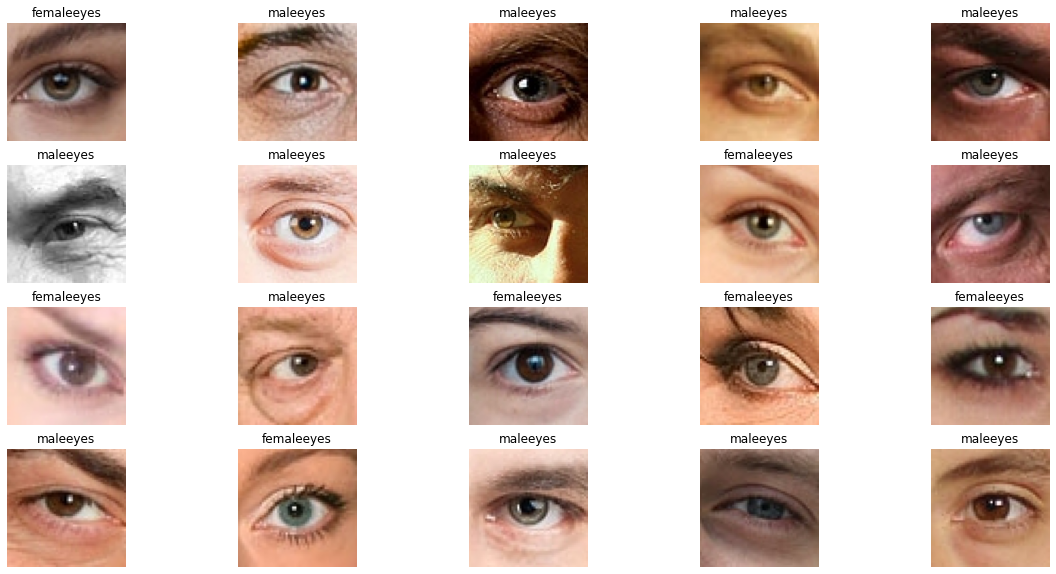

In [ ]:
#Display random images
import random

#function for displaying 1 random image and image shape
def one_random_image(target_path, target_class): 
  target_fold = target_path + target_class
  random_image = random.sample(os.listdir(target_fold), 1)
  image = mpimg.imread(target_fold+'/'+random_image[0])
  plt.imshow(image)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {image.shape}")

  return image

#Function for displaying group of random images and shape
def group_random_images( target_path, figure_size=(20, 10), group=20):
  plt.figure(figsize=figure_size)
  for i in range(group):
    plt.subplot(4, 5, i+1)
    class_name = random.choice(['maleeyes', 'femaleeyes'])
    image = one_random_image(target_path=target_path, target_class=class_name)
  
group_random_images = group_random_images(target_path='/content/eyes/split_dataset/train/')

In [ ]:
## saving train and validation path into variable
train_set = '/content/eyes/split_dataset/train'
val_set = '/content/eyes/split_dataset/val'

In [ ]:
#image augmentation
#training set rescale and augmenting
train_aug = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    zoom_range=0.2,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

#only rescale the validation set, dont do the augmentation step for validation set, it might cause bias
valid_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
#train and validation data generator
#batch size 64
#class mode is categorical since we have 5 classes
train_generator = train_aug.flow_from_directory(
        train_set,  
        target_size=(60, 60),  
        batch_size=64,
        class_mode='binary')

validation_generator = valid_aug.flow_from_directory(
        val_set, 
        target_size=(60, 60), 
        batch_size=64, 
        class_mode='binary')

Found 9219 images belonging to 2 classes.
Found 2306 images belonging to 2 classes.


In [ ]:
#building model 
#using 2 hidden layer 
#using softmax in output layer instead of sigmoid because there are 6 outcomes
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (60,60,3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,(3,3), activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128,(3,3), activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation= 'relu'),
    layers.Dense(1, activation= 'sigmoid') #binary so output layer input dim is 1 and activation sigmoid
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 58, 58, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)             

In [ ]:
# Adding lose function and optimizer
#categorical since we have 3 classes
#using adam 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

In [ ]:
# Add early stop to prevent overfitting
minimum_change = 0.01 #minimum change to be considered an improvement
epoch_stop = 5 #number of epoch to wait before stopping
early_stop = EarlyStopping(
    min_delta = minimum_change, 
    patience= epoch_stop, 
    restore_best_weights=True,
)

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    epochs=40, 
    steps_per_epoch=20,
    validation_data = validation_generator,
    verbose = 1,
    validation_steps=10,
    callbacks=[early_stop],
)

Epoch 1/40
20/20 [==============================] - 10s 447ms/step - loss: 0.6876 - binary_accuracy: 0.5578 - val_loss: 0.6626 - val_binary_accuracy: 0.6016
Epoch 2/40
20/20 [==============================] - 9s 436ms/step - loss: 0.6609 - binary_accuracy: 0.6031 - val_loss: 0.6449 - val_binary_accuracy: 0.6375
Epoch 3/40
20/20 [==============================] - 9s 437ms/step - loss: 0.6045 - binary_accuracy: 0.6781 - val_loss: 0.5253 - val_binary_accuracy: 0.7484
Epoch 4/40
20/20 [==============================] - 9s 436ms/step - loss: 0.5626 - binary_accuracy: 0.7109 - val_loss: 0.4843 - val_binary_accuracy: 0.7766
Epoch 5/40
20/20 [==============================] - 9s 435ms/step - loss: 0.5668 - binary_accuracy: 0.6992 - val_loss: 0.5197 - val_binary_accuracy: 0.7469
Epoch 6/40
20/20 [==============================] - 8s 413ms/step - loss: 0.5120 - binary_accuracy: 0.7457 - val_loss: 0.4388 - val_binary_accuracy: 0.7937
Epoch 7/40
20/20 [==============================] - 9s 436ms/st

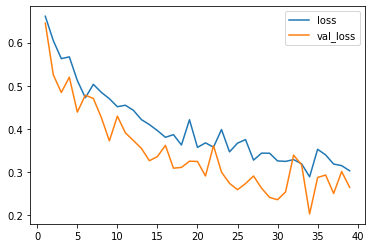

In [ ]:
#loss 
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
plt.show()

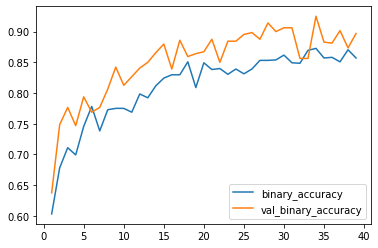

In [ ]:
#accuracy 
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()
plt.show()

In [ ]:
#Best validation loss and accuracy score
print(("Best Validation Loss: {:0.2f}" +"\nBest Validation Accuracy: {:0.2f}").format(history_df['val_loss'].min(), history_df['val_binary_accuracy'].max()))

Best Validation Loss: 0.20
Best Validation Accuracy: 0.93
